# E.R.A. Analysis

### MSP, 4.9.2017

A study of the 2016 season's ERA secrets, trying to look at what we might expect for this year (and just generally getting our bearings on ERA).

The cell below this toggles the code on and off; I've left it off by default for a clean read of the findings.

In [1]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# basic imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl


%matplotlib inline

In [3]:
# read in fangraphs-ripped stats. specifications:
#    fangraphs-denoted starter


def read_individual_standard_stats(infile):
    return np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","W","L","ERA","G","GS","CG","ShO",\
                                   "SV","HLD","BS","IP","TBF","H","R","ER","HR","BB",\
                                   "IBB","HBP","WP","BK","SO","playerid"),\
                         'formats': ('S20','S20','f4','f4','f4','f4','f4','f4','f4',\
                                    'i2','i2','i2','f4','i2','i2','i2','i2','i2','f4',\
                                    'f4','f4','f4','f4','f4','i4')},\
                 skip_header=1,delimiter=',')

def read_individual_battedball_stats(infile):
    return np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","BABIP","GB/FB","LD","GB","FB","IFFB","HRFB",\
                                   "RS","RS9","BLLS","STRKS","PIT","PULL","CENT","OPPO",\
                                   "SOFT","MED","HARD","playerid"),\
                         'formats': ('S20','S20','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','i4')},\
                 skip_header=1,delimiter=',')


StartersPlayers2016 = read_individual_standard_stats('2016Pitching/StartersPlayers2016.csv')
StartersBatted2016  = read_individual_battedball_stats('2016Pitching/StartersBatted2016.csv')

StartersPlayers2015 = read_individual_standard_stats('2016Pitching/StartersPlayers2015.csv')




In [4]:

#
# calculate some extra stats
#

#FIP = ((13*HR)+(3*(BB+HBP))-(2*K))/IP + constant


SP2016FIP  = (13.*StartersPlayers2016['HR'] +\
              (3.*(StartersPlayers2016['BB'] + StartersPlayers2016['HBP'])) -\
              2.*StartersPlayers2016['SO'])\
                /StartersPlayers2016['IP'] + 3.1437 # 3.143 is the 2016 correction
    
SP2016WHIP = (StartersPlayers2016['BB'] + StartersPlayers2016['H'])/StartersPlayers2016['IP']
SP2016HIP = (StartersPlayers2016['H'])/StartersPlayers2016['IP']




In [5]:


#
# match the player stats across datasets
#
PlayerDict = {}
PlayerDict['Player'] = StartersPlayers2016['Name']
PlayerDict['WHIP'] = np.zeros(len(StartersPlayers2016['Name']))
PlayerDict['BABIP'] = np.zeros(len(StartersPlayers2016['Name']))
PlayerDict['FIP'] = np.zeros(len(StartersPlayers2016['Name']))
PlayerDict['HIP'] = np.zeros(len(StartersPlayers2016['Name']))
PlayerDict['ERA'] = np.zeros(len(StartersPlayers2016['Name']))
PlayerDict['ST'] = np.zeros(len(StartersPlayers2016['Name']))

#
# also add a 100 IP threshold
#
for x in range(0,len(PlayerDict['Player'])):
    if StartersPlayers2016['IP'][x] > 100.:
        PlayerDict['WHIP'][x] = SP2016WHIP[x]
        PlayerDict['FIP'][x] = SP2016FIP[x]
        PlayerDict['HIP'][x] = SP2016HIP[x]
        PlayerDict['ERA'][x] = StartersPlayers2016['ERA'][x]
 
        try:
            xx = np.where(StartersPlayers2016['Name'][x] == StartersBatted2016['Name'])[0]
            PlayerDict['BABIP'][x] = \
              StartersBatted2016['BABIP'][xx]
            PlayerDict['ST'][x] = StartersBatted2016['STRKS'][xx]/StartersBatted2016['PIT'][xx]
        except:
            PlayerDict['BABIP'][x] = np.nan
            PlayerDict['ST'][x] = np.nan
    else:
        PlayerDict['WHIP'][x] = np.nan
        PlayerDict['FIP'][x] = np.nan
        PlayerDict['HIP'][x] = np.nan
        PlayerDict['BABIP'][x] = np.nan

You're a smart baseball fan, you know that ERA and WHIP correlate. There's dispersion, sure, but there are ways to try and mitigate that. For instance, the fraction of strikes thrown tells you something about the pitcher's control; sure enough, it helps explain a lot of the dispersion in the ERA-WHIP plane. The actual values are suble--everyone throws between 60 and 70 percent strikes--so the Strike% quantity can take a while to settle down.

That said, it's the close of first week of the season! Of course we are going to hit the small sample sizes hard.

ERA-WHIP Parameters
-------------------
('Slope=', 0.16230955504162009)
('Intercept=', 0.62785875785525658)


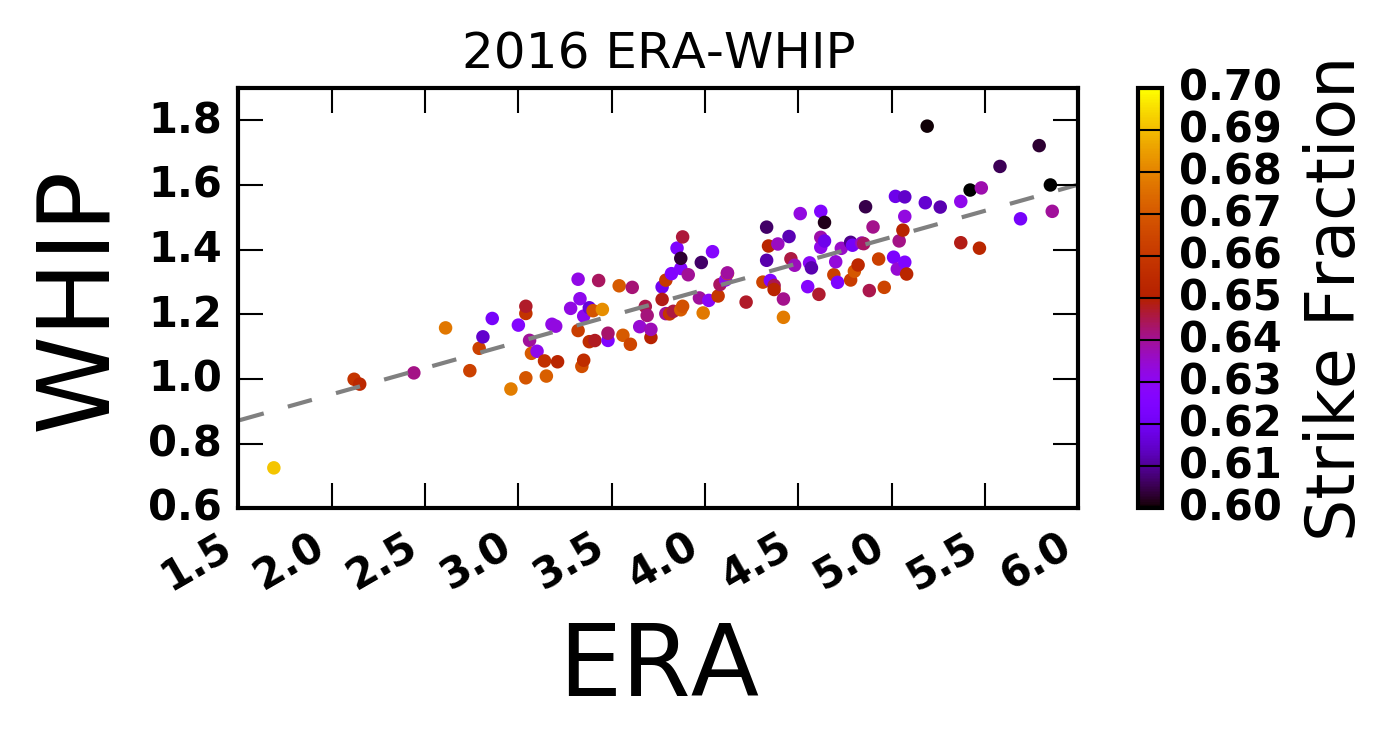

In [6]:

fig = plt.figure(figsize=(4,2))

ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])

# find valid values and plot
goodw = np.where(PlayerDict['BABIP'] > 0.)[0]
ax.scatter(PlayerDict['ERA'][goodw],PlayerDict['WHIP'][goodw],\
            color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)


ax.axis([1.5,6.,0.6,1.9])
ax.set_ylabel('WHIP',size=24)
ax.set_xlabel('ERA',size=24)
for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("right")

ax.set_title('2016 ERA-WHIP')



# fit a linear model to valid values
goodw = np.where(PlayerDict['ERA'] > 0.)[0]
c = np.polyfit(PlayerDict['ERA'][goodw],PlayerDict['WHIP'][goodw],1)
d = np.poly1d(c)
ax.plot(np.linspace(0.0,6.0,100),d(np.linspace(0.0,6.0,100)),color='gray',lw=1.,linestyle='dashed')

cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=16)

print('ERA-WHIP Parameters')
print('-------------------')
print('Slope=',c[0])
print('Intercept=',c[1])



The yellow point waaaaay down in the awesome corner (lower left) is Clayton Kershaw. He makes me rescale all my graphs.

What about fielding, though? We're moving to something like FIP (fielding-independent-pitching), but trying to keep the metrics simpler, and without any sort of tunable scaling fractions. Let's start with BABIP, and look at the correlation with ERA (keep Strike% as the third dimension.)

ERA-BABIP Parameters
-------------------
('Slope=', 20.587874349718398)
('Intercept=', -1.9289156985195581)


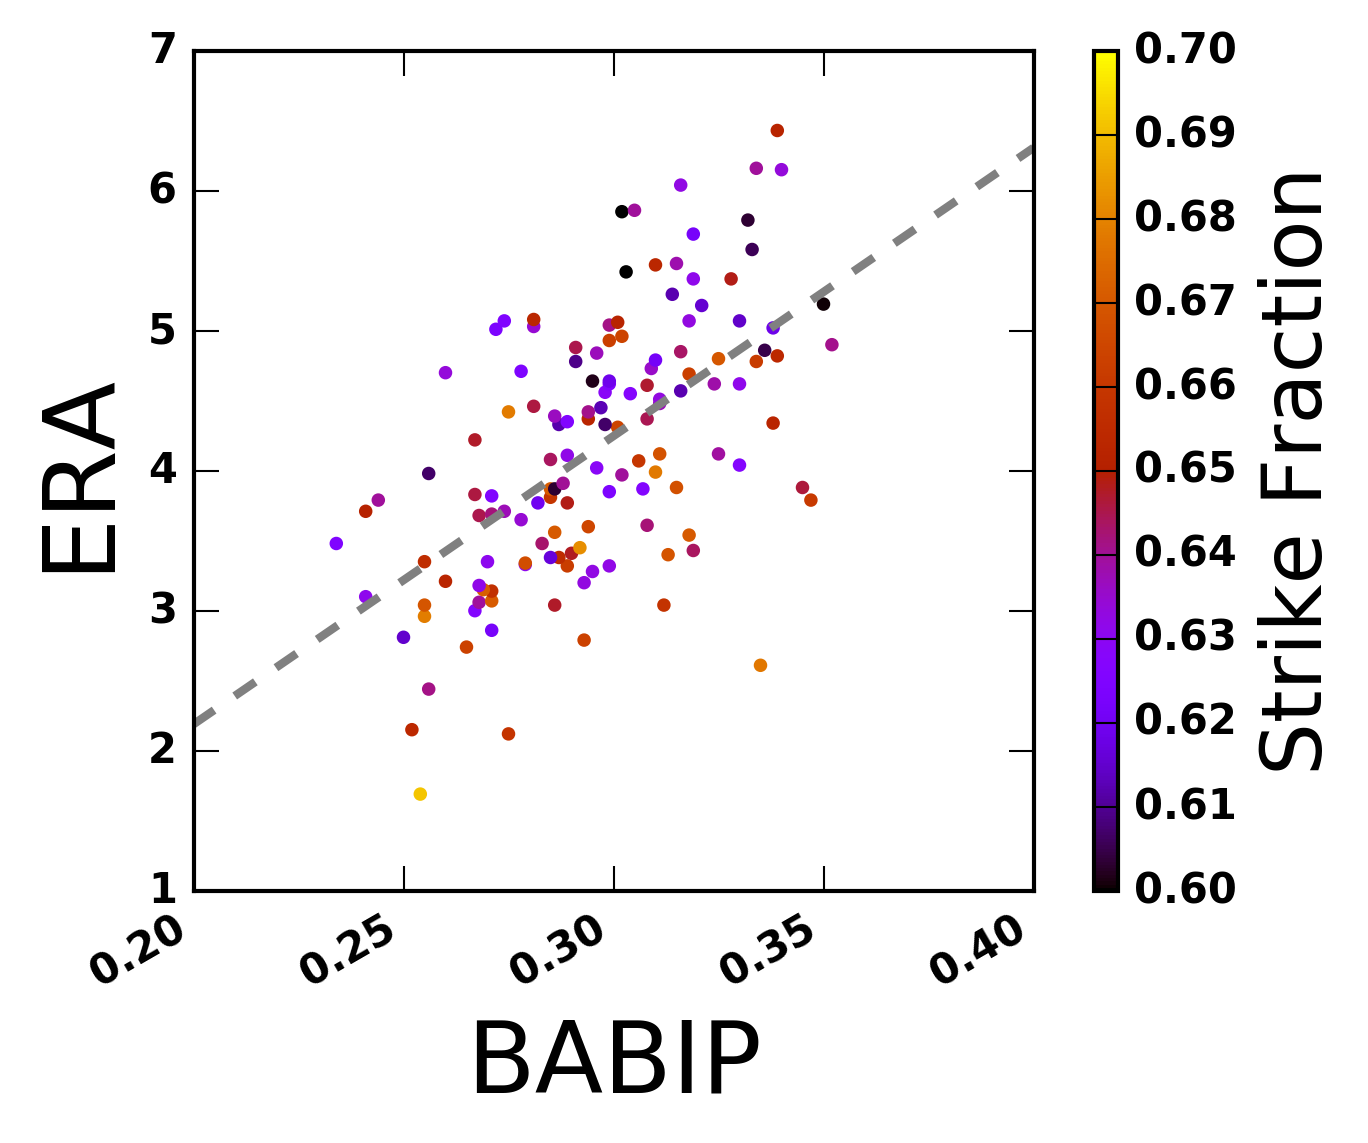

In [7]:


fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])

# find only pitchers with batted ball data
goodw = np.where(PlayerDict['BABIP'] > 0.)[0]

ax.scatter(PlayerDict['BABIP'][goodw],PlayerDict['ERA'][goodw],\
           color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)

cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=20)

c = np.polyfit(PlayerDict['BABIP'][goodw],PlayerDict['ERA'][goodw],1)
d = np.poly1d(c)

ax.plot(np.linspace(.2,.4,100),d(np.linspace(.2,.4,100)),color='gray',linestyle='dashed')

ax.axis([0.2,0.4,1.,7.])
ax.set_ylabel('ERA',size=24)
ax.set_xlabel('BABIP',size=24)

for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")

        
print('ERA-BABIP Parameters')
print('-------------------')
print('Slope=',c[0])
print('Intercept=',c[1])




The next step is to set up the regression to see what we might expect from players going forward. I've already fit a simple linear model in the figure above, so let's use it to look at outliers:

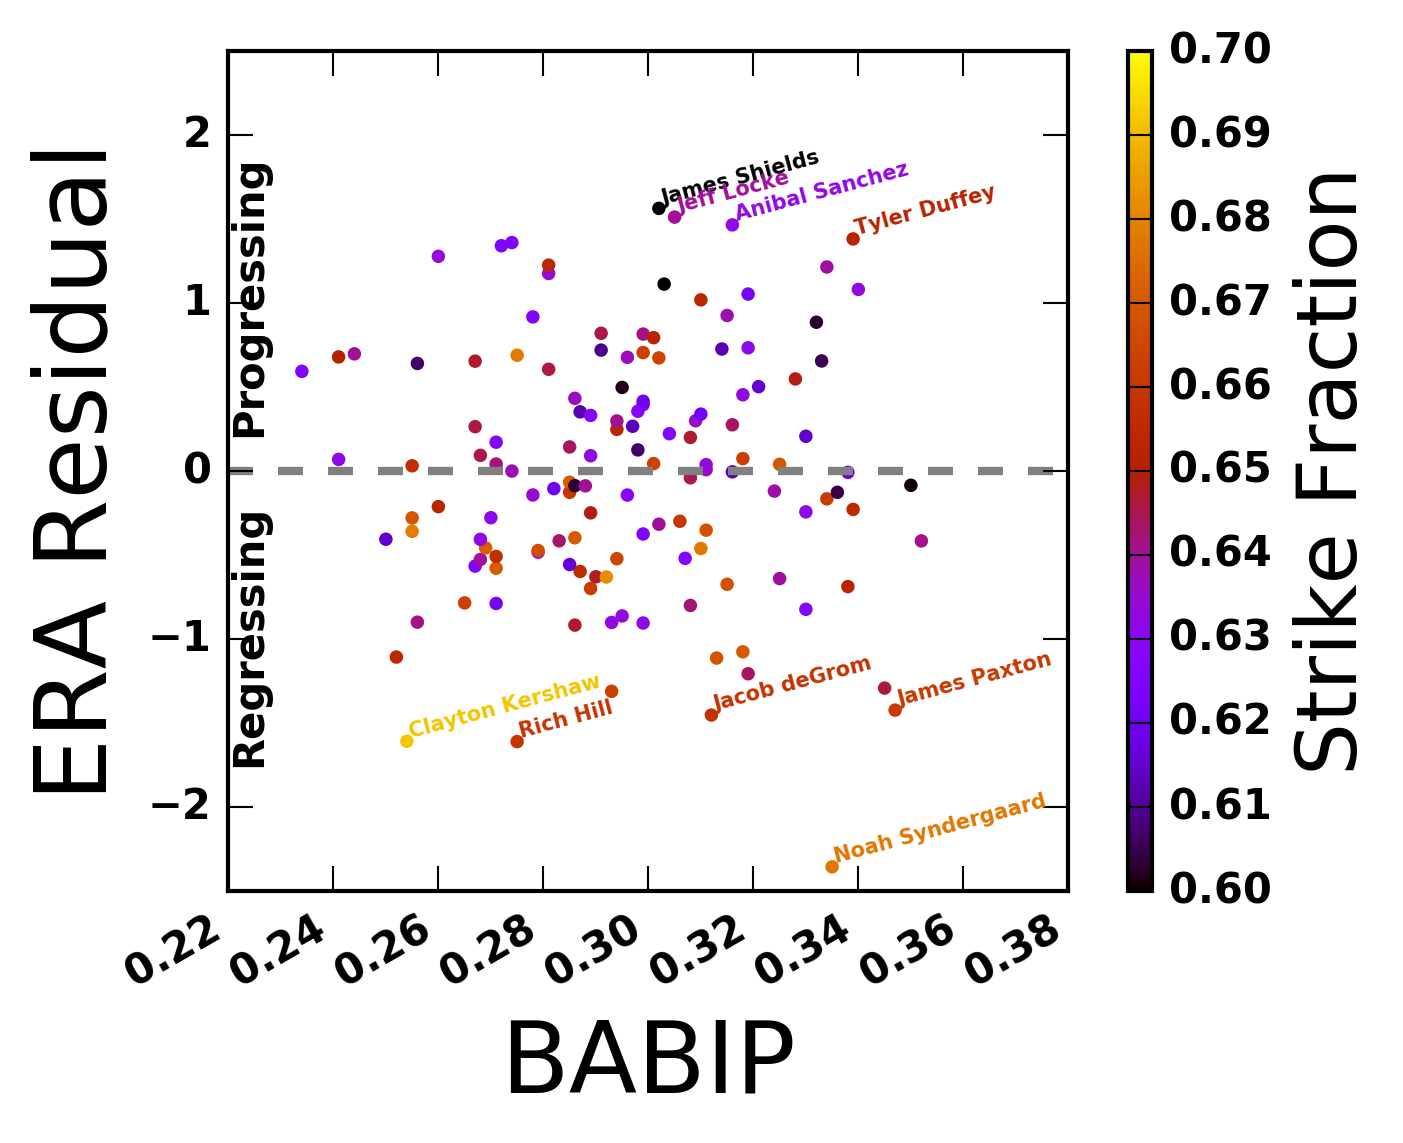

In [8]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])


goodw = np.where(PlayerDict['BABIP'] > 0.)[0]



model = PlayerDict['ERA'][goodw] - d(PlayerDict['BABIP'][goodw])
cbar = ax.scatter(PlayerDict['BABIP'][goodw],model,\
                  color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)

ax.plot([0.22,0.38],[0.,0.],color='gray',linestyle='dashed')

ax.axis([0.22,0.38,-2.5,2.5])
ax.set_xlabel('BABIP',size=24)
ax.set_ylabel('ERA Residual',size=24)
ax.text(0.22,-0.2,'Regressing',rotation=90,va='top')
ax.text(0.22,0.2,'Progressing',rotation=90,va='bottom')

for indx in goodw:
    modval = PlayerDict['ERA'][indx] - d(PlayerDict['BABIP'][indx])
    if (PlayerDict['BABIP'][indx] > 0.0) & (modval > 1.36):
        ax.text(PlayerDict['BABIP'][indx],modval,PlayerDict['Player'][indx],size=5,rotation=15,ha='left',va='bottom',color=cm.gnuplot((PlayerDict['ST'][indx]-0.6)/0.1,1.))
    if (PlayerDict['BABIP'][indx] > 0.0) & (modval < -1.4):
        ax.text(PlayerDict['BABIP'][indx],modval,PlayerDict['Player'][indx],size=5,rotation=15,ha='left',va='bottom',color=cm.gnuplot((PlayerDict['ST'][indx] -0.6)/0.1,1.))


cmap = mpl.cm.gnuplot
norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=20)

for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("right")

Let's bullet a little story about the progressing guys in order of excitement:
1. **Tyler Duffey** is currently languishing in relief for the Twins (embarassing). He's only faced 11 batters, but he's throwing the same profile as last year (Strike%)
2. **James Shields** still needs to hit the strike zone (<60 Strike%), and had a BABIP of 0.083 in his first start, so let's not get too excited.
3. **Jeff Locke** is on the DL. Bummer. Still, someone to watch in his first few starts.
4. My computer likes to try to correct **Anibal Sanchez** to _Animal_ Sanchez. He's not an animal. He got a little unlucky in relief for the Tigers (BABIP of .400), with a little lower similar Strike% as last year.

And the regressing guys, in order of doubt that they will regress:
1. **Clayton Kershaw**. Sure, he gave up hits in Coors. He's human after all (though you wouldn't know if from his Strike%)!
2. **Jake deGrom**. Ball stayed on the ground during the first start, BABIP was normal (for the Mets), throws the same amount of strikes as ever. ERA prediction: 3.0
3. **Noah Syndergaard** had basically the same first outing as deGrom. Still expecting a little regression--think 3.60. on the ERA, not 2.60--but also don't think 4.60.
4. **Rich Hill** is old and got a blister on his finger, though he still pitched a very solid first game for the Dodgers. He's lived off low BABIP for a couple years; I can't see a sub-3.0 ERA for him, but then again, that would be a huge regression.
5. **James Paxton** is terrible. His first outing was not terrible, but do not be fooled. 

Got a pitcher you're interested in the regression on? Drop us a line!

To bring this all home, let's use FIP anyway (even though I don't like it).


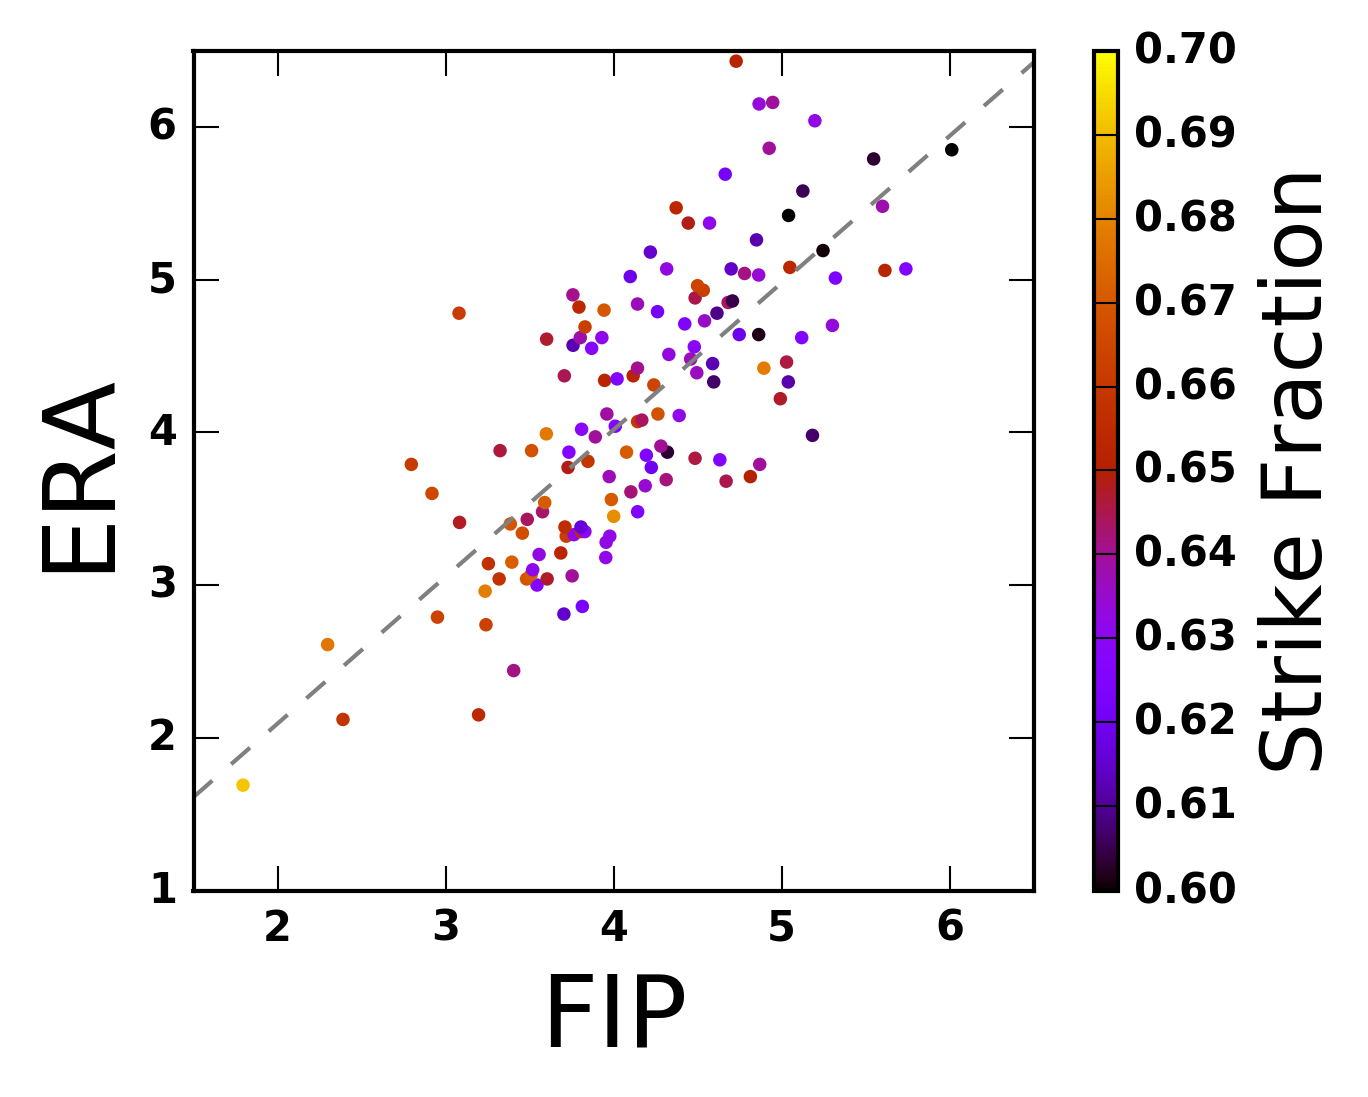

In [9]:

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])


goodw = np.where(PlayerDict['BABIP'] > 0.)[0]



ax.scatter(PlayerDict['FIP'][goodw],PlayerDict['ERA'][goodw],\
           color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)


c = np.polyfit(PlayerDict['FIP'][goodw],PlayerDict['ERA'][goodw],1)
d = np.poly1d(c)
ax.plot(np.linspace(1.5,6.5,100),d(np.linspace(1.5,6.5,100)),color='gray',lw=1.,linestyle='dashed')

ax.axis([1.5,6.5,1.,6.5])
ax.set_xlabel('FIP',size=24)
ax.set_ylabel('ERA',size=24)

cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=20)



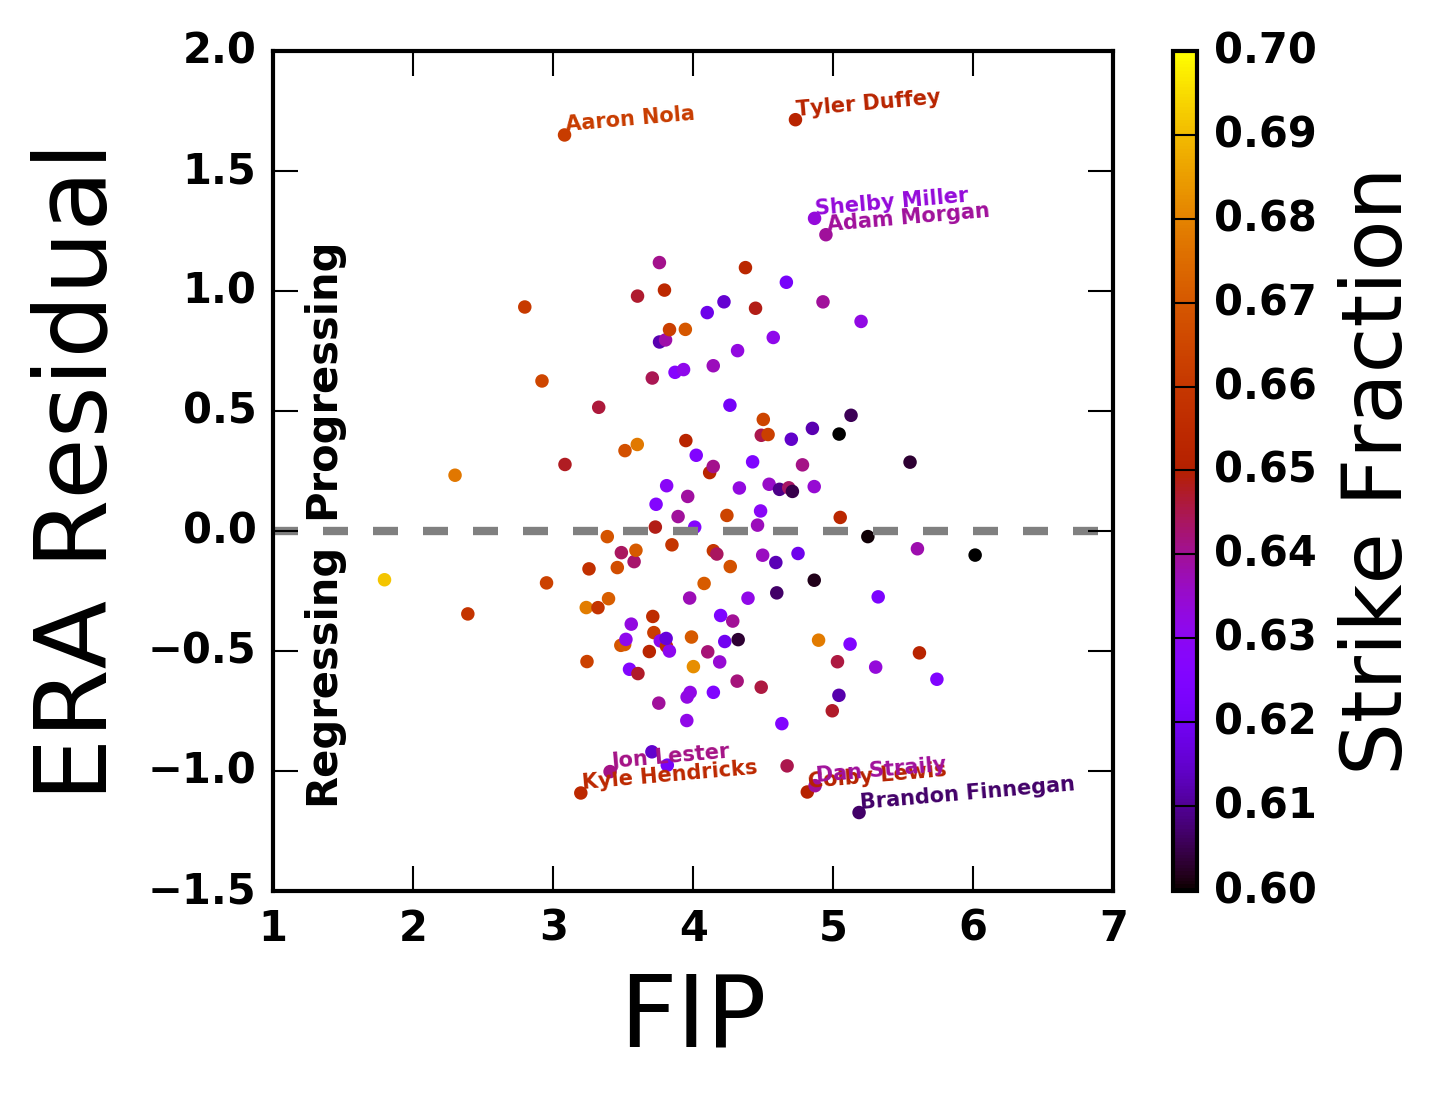

In [10]:

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])


goodw = np.where(PlayerDict['BABIP'] > 0.)[0]


model = PlayerDict['ERA'][goodw] - d(PlayerDict['FIP'][goodw])
ax.scatter(PlayerDict['FIP'][goodw],model,\
           color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)


ax.plot([1.,7.],[0.,0.],color='gray',linestyle='dashed')

ax.axis([1.,7.,-1.5,2.])
ax.set_xlabel('FIP',size=24)
ax.set_ylabel('ERA Residual',size=24)
ax.text(1.2,-0.05,'Regressing',rotation=90,va='top')
ax.text(1.2,0.05,'Progressing',rotation=90,va='bottom')


for indx in goodw:
    modval = PlayerDict['ERA'][indx] - d(PlayerDict['FIP'][indx])
    if (PlayerDict['FIP'][indx] > 0.0) & (modval > 1.2):
        ax.text(PlayerDict['FIP'][indx],modval,PlayerDict['Player'][indx],size=5,rotation=5,ha='left',va='bottom',color=cm.gnuplot((PlayerDict['ST'][indx]-0.6)/0.1,1.))
    if (PlayerDict['FIP'][indx] > 0.0) & (modval < -1.0):
        ax.text(PlayerDict['FIP'][indx],modval,PlayerDict['Player'][indx],size=5,rotation=5,ha='left',va='bottom',color=cm.gnuplot((PlayerDict['ST'][indx] -0.6)/0.1,1.))


cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=20)




Takeaways:
1. BABIP (and therefore FIP) more weakly disperse pitchers in ERA than WHIP does--therefore, stick to WHIP.
2. Strike% is a legit tool to be a third dimension.
3. This probably has something to do with the underlying command (walks and strike% are correlated). 

Does this tell us why pitch framing is actually crucial? I'm going to be watching **Jon Lester** to find out. Either way, command is a big deal for ERA and WHIP, so while you can rely on some surface stats, I think we're headed for statcast to make a full pitching model.

And for the second straight analysis, I'm being told to watch out for **Dan Straily**. Damn.